In [6]:
import pandas as pd
import numpy as np
import datetime
import holidays

import networkx as nx
from matplotlib import pyplot as plt

from utils import *

In [57]:
trip_DF = create_trip_DF('/content/January2019.csv')
print(len(trip_DF.index))

7038796


In [58]:
trip_DF.describe()

,trip_distance,pickup_location_ID,dropoff_location_ID,fare_amount
count,7.038796e+06,7.038796e+06,7.038796e+06,7.038796e+06
mean,2.834218e+00,1.652930e+02,1.635873e+02,1.228373e+01
std,3.757160e+00,6.639384e+01,7.038780e+01,2.352003e+02
min,1.000000e-02,1.000000e+00,1.000000e+00,2.500000e+00
25%,9.200000e-01,1.250000e+02,1.130000e+02,6.000000e+00
50%,1.560000e+00,1.620000e+02,1.620000e+02,9.000000e+00
75%,2.840000e+00,2.340000e+02,2.340000e+02,1.350000e+01
max,8.318000e+02,2.650000e+02,2.650000e+02,6.232599e+05


In [ ]:
append_and_fill_time_of_day_bins(trip_DF, time_of_day_bins)

PU_time_2AM-5:59AM
PU_time_6AM-9:59AM


In [13]:
trip_DF['pickup_date'] = trip_DF['pickup_datetime'].map(lambda timestamp: timestamp.date())

In [15]:
trip_avg_fare_DF = create_avg_fare_df(trip_DF)

In [16]:
# if trips occur on weekend or US holiday
trip_avg_fare_DF['weekend/holiday'] = trip_avg_fare_DF['pickup_date'].map(lambda date: 1 if is_weekend_or_holiday(date) else 0)

In [19]:
## Enforce that pickup and dropoff IDs are ints
trip_avg_fare_DF = trip_avg_fare_DF.astype({"pickup_location_ID": int, "dropoff_location_ID": int})

In [20]:
trip_avg_fare_DF.head(10)

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday
0,1,1,2019-01-01,0,0,0,0,0,1,73.000000,1
1,1,1,2019-01-01,0,0,0,0,1,0,46.000000,1
2,1,1,2019-01-01,0,0,0,1,0,0,72.500000,1
3,1,1,2019-01-01,0,0,1,0,0,0,67.777778,1
4,1,1,2019-01-01,0,1,0,0,0,0,106.666667,1
5,1,1,2019-01-01,1,0,0,0,0,0,52.500000,1
6,1,1,2019-01-02,0,0,0,0,1,0,75.500000,0
7,1,1,2019-01-02,0,0,0,1,0,0,52.166667,0
8,1,1,2019-01-02,0,0,1,0,0,0,68.142857,0
9,1,1,2019-01-02,0,1,0,0,0,0,75.000000,0


In [21]:
len(trip_avg_fare_DF.index)

111022

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf86e653c8>]],
      dtype=object)

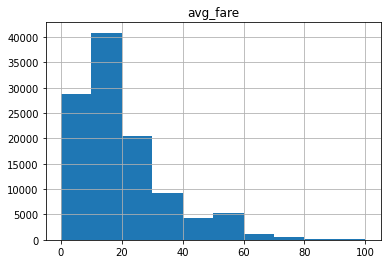

In [22]:
trip_avg_fare_DF.hist(column="avg_fare", bins=10, range=(0, 100))

In [23]:
## Need to drop the following columns when doing training & testing
## 1. pickup_location_ID
## 2. dropoff_location_ID
## 3. pickup_date
## 4. avg_fare as this is the target

In [28]:
## Construct 1-hot vectors for pickup and dropoff locations
trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['pickup_location_ID'], prefix='PU_ID')], axis=1)
trip_avg_fare_DF = pd.concat([trip_avg_fare_DF, pd.get_dummies(trip_avg_fare_DF['dropoff_location_ID'], prefix='DO_ID')], axis=1)

In [29]:
trip_avg_fare_DF.head(10)

,pickup_location_ID,dropoff_location_ID,pickup_date,PU_time_2AM-5:59AM,PU_time_6AM-9:59AM,PU_time_10AM-1:59PM,PU_time_2PM-5:59PM,PU_time_6PM-9:59PM,PU_time_10PM-1:59AM,avg_fare,weekend/holiday,PU_ID_1,PU_ID_2,PU_ID_3,PU_ID_4,PU_ID_5,PU_ID_6,PU_ID_7,PU_ID_8,PU_ID_9,PU_ID_10,PU_ID_11,PU_ID_12,PU_ID_13,PU_ID_14,PU_ID_15,PU_ID_16,PU_ID_17,PU_ID_18,PU_ID_19,PU_ID_20,PU_ID_21,PU_ID_22,PU_ID_23,PU_ID_24,PU_ID_25,PU_ID_26,PU_ID_28,PU_ID_29,PU_ID_30,...,DO_ID_226,DO_ID_227,DO_ID_228,DO_ID_229,DO_ID_230,DO_ID_231,DO_ID_232,DO_ID_233,DO_ID_234,DO_ID_235,DO_ID_236,DO_ID_237,DO_ID_238,DO_ID_239,DO_ID_240,DO_ID_241,DO_ID_242,DO_ID_243,DO_ID_244,DO_ID_245,DO_ID_246,DO_ID_247,DO_ID_248,DO_ID_249,DO_ID_250,DO_ID_251,DO_ID_252,DO_ID_253,DO_ID_254,DO_ID_255,DO_ID_256,DO_ID_257,DO_ID_258,DO_ID_259,DO_ID_260,DO_ID_261,DO_ID_262,DO_ID_263,DO_ID_264,DO_ID_265
0,1,1,2019-01-01,0,0,0,0,0,1,73.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,2019-01-01,0,0,0,0,1,0,46.000000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,2019-01-01,0,0,0,1,0,0,72.500000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,2019-01-01,0,0,1,0,0,0,67.777778,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2019-01-01,0,1,0,0,0,0,106.666667,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,1,2019-01-01,1,0,0,0,0,0,52.500000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,2019-01-02,0,0,0,0,1,0,75.500000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,2019-01-02,0,0,0,1,0,0,52.166667,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,2019-01-02,0,0,1,0,0,0,68.142857,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,2019-01-02,0,1,0,0,0,0,75.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
